# Download Final Data

# Import Libraries

In [21]:
import pandas as pd, numpy as np

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, log_loss

from sklearn.feature_selection import RFE

from sklearn.metrics import (auc, classification_report, roc_auc_score,roc_curve,recall_score)
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Import Data and define global variables

In [2]:
X_train = pd.read_csv('train_75.csv', index_col = 0)

y_train = pd.read_csv('train_target.csv', index_col = 0).iloc[:,0]

X_test = pd.read_csv('test_75.csv', index_col = 0)

# Transform!

In [3]:
def z_norm(x):
    
    res = (x - x.mean()) / x.std()
    
    return res

X_test.iloc[:,60:67].head()

,team1_elo,team2_elo,team1_elv_diff,team2_elv_diff,host_elv,team1_elv,team2_elv
0,100.0,57.142857,129.095609,172.104489,10.430255,139.525864,182.534744
1,100.0,0.000000,129.095609,970.228803,10.430255,139.525864,980.659058
2,100.0,147.368421,129.095609,405.422925,10.430255,139.525864,415.853180
3,100.0,30.769231,129.095609,277.075727,10.430255,139.525864,287.505981
4,100.0,40.000000,129.095609,18.804208,10.430255,139.525864,29.234463


In [4]:
for i in range(60, 68):
    X_test.iloc[:,i] = z_norm(X_test.iloc[:,66])

for i in range(60, 68):
    X_train.iloc[:,i] = z_norm(X_train.iloc[:,66])


X_test.iloc[:,60:67].head()

,team1_elo,team2_elo,team1_elv_diff,team2_elv_diff,host_elv,team1_elv,team2_elv
0,-0.271798,-0.271798,-0.271798,-0.271798,-0.271798,-0.271798,-0.271798
1,2.767374,2.767374,2.767374,2.767374,2.767374,2.767374,2.767374
2,0.616653,0.616653,0.616653,0.616653,0.616653,0.616653,0.616653
3,0.127921,0.127921,0.127921,0.127921,0.127921,0.127921,0.127921
4,-0.855550,-0.855550,-0.855550,-0.855550,-0.855550,-0.855550,-0.855550


In [5]:
def top_40_plus(model, X, y):

    rfe = RFE(model, 40)
    fit = rfe.fit(X, y)
    
    keep = []
    for i,a in enumerate(fit.support_):
        if (a == True):
            keep.append(i)
    
    return keep

In [6]:
def lr(X_train, y_train, X_test):

    lr = BaggingClassifier(base_estimator = LogisticRegression())
    lr.fit(X_train, y_train)
    y_pred = lr.predict_proba(X_test)
    
    return y_pred

In [7]:
def nb(X_train, y_train, X_test):
    
    nb = BaggingClassifier(base_estimator = GaussianNB())
    nb.fit(X_train,y_train)
    y_pred = nb.predict_proba(X_test)
    
    return y_pred

In [8]:
def rf(X_train, y_train, X_test):
    
    rf = BaggingClassifier(base_estimator = RandomForestClassifier())
    rf.fit(X_train,y_train)
    y_pred = rf.predict_proba(X_test)
    
    return y_pred

In [9]:
def sv(X_train, y_train, X_test):
    
    sv = BaggingClassifier(base_estimator = SVC(probability = True))
    sv.fit(X_train,y_train)
    y_pred = sv.predict_proba(X_test)
    
    return y_pred

In [10]:
def gb(X_train, y_train, X_test):

    gb = BaggingClassifier(base_estimator = GradientBoostingClassifier())
    gb.fit(X_train, y_train)
    y_pred = gb.predict_proba(X_test)
    
    return y_pred

In [14]:
#X_train, X_test, y_train, y_test = train_test_split(X_train ,y_train, test_size = 0.3, random_state = 42)

In [24]:
def ensemble(X_train, y_train, X_test):
    lr_keep = top_40_plus(LogisticRegression(), X_train, y_train)

    # Declared Globally
    # X_train, X_test, y_train, y_test 
   
    lr_y = lr(X_train.iloc[:,lr_keep], y_train, X_test.iloc[:,lr_keep])
    sv_y = sv(X_train.iloc[:,lr_keep], y_train, X_test.iloc[:,lr_keep])
    rf_y = rf(X_train.iloc[:,lr_keep], y_train, X_test.iloc[:,lr_keep])
    nb_y = nb(X_train.iloc[:,lr_keep], y_train, X_test.iloc[:,lr_keep])
    gb_y = gb(X_train.iloc[:,lr_keep], y_train, X_test.iloc[:,lr_keep])
    
    final_y = []
    
    for i in range(len(X_test)):
        final_y.append((lr_y[i][1]+ nb_y[i][1]+rf_y[i][1]+ sv_y[i][1]+ gb_y[i][1])/5)
        
    return final_y


In [25]:
e100 = ensemble(X_train, y_train, X_test)

In [30]:
pd.DataFrame({"Proba_Win":e100}).to_csv("Soft_5_probability.csv")

In [41]:
pd.Series(ebinary).value_counts()/(2130+148)

1    0.935031
0    0.064969
dtype: float64

In [26]:
log_loss(y_test, e100)

0.56325876908039985

In [27]:
ebinary = []

for i in range(len(e100)):    
    if (e100[i] > 0.5): 
        ebinary.append(1)
    else:
        ebinary.append(0)

In [28]:
accuracy_score(ebinary, y_test)

0.71565495207667729

## ROC Curve

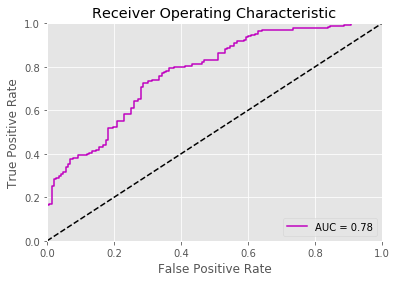

In [29]:
def plot_roc(fpr, tpr, roc_auc):
    """Plots the ROC curve for the win probability model along with
    the AUC.
    """
    fig, ax = plt.subplots()
    ax.set(title='Receiver Operating Characteristic',
           xlim=[0, 1], ylim=[0, 1], xlabel='False Positive Rate',
           ylabel='True Positive Rate')
    ax.plot(fpr, tpr, 'm', label='AUC = %0.2f' % roc_auc)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.legend(loc='lower right')
    
fpr, tpr, thresholds = roc_curve(y_test, e100)
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc)